In [1]:
import time
import numpy as np
import networkx as nx
from treesampling import algorithms
from treesampling.utils.graphs import random_uniform_graph, random_tree_skewed_graph, tuttes_tot_weight, normalize_graph_weights, reset_adj_matrix, tree_to_newick, graph_weight

In [2]:
records = []
# generate uniform graphs
n_nodes = 6
root = 0
graph = random_uniform_graph(n_nodes)
norm_graph = normalize_graph_weights(graph)
tot_weight = tuttes_tot_weight(norm_graph, root)
log_graph = reset_adj_matrix(graph, np.log(nx.to_numpy_array(graph)))

sample_size = 2000
sample = {}
acc_w = 0
num = 0
for i in range(sample_size):
    tree = algorithms.jens_rst(log_graph, root=root)
    tree_nwk = tree_to_newick(tree)
    if tree_nwk not in sample:
        weight = np.exp(graph_weight(tree, log_probs=True))
        sample[tree_nwk] = weight
        acc_w += weight
        num += 1
        records.append([i, acc_w / tot_weight, acc_w, num, 'unif'])

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_11594/2859255398.py:8: RuntimeWarning: divide by zero encountered in log
  log_graph = reset_adj_matrix(graph, np.log(nx.to_numpy_array(graph)))


In [9]:
# same as above, but with matrix skewed on one tree
records = []
time_rec = []
rand_k_param = 100
for n_nodes in [6, 7, 8, 9, 10]:
    graph, target_tree = random_tree_skewed_graph(n_nodes, rand_k_param)
    target_tree_nwk = tree_to_newick(target_tree)
    mst_nwk = tree_to_newick(nx.maximum_spanning_arborescence(graph))
    print(f"{n_nodes} nodes graph skewed towards: {target_tree_nwk}")
    print(f"MST: {mst_nwk}" + (" different!" if target_tree_nwk != mst_nwk else ""))
    norm_graph = normalize_graph_weights(graph)
    tot_weight = tuttes_tot_weight(norm_graph, root)
    log_graph = reset_adj_matrix(graph, np.log(nx.to_numpy_array(graph)))

    sample_size = 10000
    sample = {}
    acc_w = 0
    target_cnt = 0
    num = 0
    start_time = time.time()
    for i in range(sample_size):
        tree = algorithms.jens_rst(log_graph, root=root)
        tree_nwk = tree_to_newick(tree)
        if tree_nwk == target_tree_nwk:
            target_cnt += 1
        if tree_nwk not in sample:
            weight = np.exp(graph_weight(tree, log_probs=True))
            sample[tree_nwk] = weight
            acc_w += weight
            num += 1
            records.append([i, acc_w / tot_weight, acc_w, num, n_nodes, str(rand_k_param)+'-tree'])
    print(f" target_cnt ({target_cnt}) / sample_size ({sample_size}) = {target_cnt / sample_size}")
    end_time = time.time() - start_time
    time_rec.append([n_nodes, end_time])


6 nodes graph skewed towards: (1,(4)2,3,5)0
MST: (1,(4)2,3,5)0
 target_cnt (131) / sample_size (10000) = 0.0131
7 nodes graph skewed towards: (((((1,5)2)3)6)4)0
MST: (((((1,5)2)3)6)4)0
 target_cnt (5415) / sample_size (10000) = 0.5415
8 nodes graph skewed towards: ((4,((3,5)1)7)2,6)0
MST: ((4,((3,5)1)7)2,6)0
 target_cnt (470) / sample_size (10000) = 0.047
9 nodes graph skewed towards: ((4,(2,(1)5)8)3,(6)7)0
MST: ((4,(2,(1)5)8)3,(6)7)0
 target_cnt (287) / sample_size (10000) = 0.0287
10 nodes graph skewed towards: ((3)6,((1,(2)4,(8)5)9)7)0
MST: ((3)6,((1,(2)4,(8)5)9)7)0
 target_cnt (195) / sample_size (10000) = 0.0195


MAKE TEST: some trees are more difficult to sample than others, just based on the topology

In [4]:
# fix k, fix sample size, fix skeweness param. for n times, run random_tree_skewed_graph and get samples.
# then find the top 3 and worst 3 cases based on target_cnt / sample size, and draw their trees
# Q: what characterizes the good/bad sampling?

k = 7
ss = 2000
skewness = 100
n_iter = 100
scores = []
trees = []
for _ in range(n_iter):
    graph, tree = random_tree_skewed_graph(k, skewness)
    log_graph = reset_adj_matrix(graph, np.log(nx.to_numpy_array(graph)))
    trees.append(tree)
    tree_nwk = tree_to_newick(tree)
    scores.append(0)
    for i in range(ss):
        samp_tree = algorithms.jens_rst(log_graph, root=0)
        if tree_to_newick(samp_tree) == tree_nwk:
            scores[-1] += 1
    scores[-1] /= sample_size
        

In [5]:
arg_scores = np.argsort(scores)
print(f"top-3: {' | '.join([tree_to_newick(trees[i])+'['+str(scores[i])+']' for i in arg_scores[:3]])}")
print(f"worst-3: {' | '.join([tree_to_newick(trees[i])+'['+str(scores[i])+']' for i in arg_scores[-3:]])}")


top-3: (2,(1,3,4)5,6)0[0.004] | (((3)5)1,2,4,6)0[0.0062] | (2,(4)3,(1,6)5)0[0.0094]
worst-3: ((((((1)3)6)5)2)4)0[0.3316] | ((((((2)1)3)6)5)4)0[0.3354] | ((((((5)1)4)6)3)2)0[0.3356]


In [10]:
import pandas as pd
rec_df = pd.DataFrame(records, columns=['n_draws', 'acc_prob', 'draw_prob', 'acc_discovery', 'n_nodes', 'graph_type'])
time_df = pd.DataFrame(time_rec, columns=['n_nodes', 'time'])
rec_df.to_csv(f'./convergence_in_prob_{rand_k_param}-tree.csv')
time_df.to_csv('./time_by_nodes.csv')

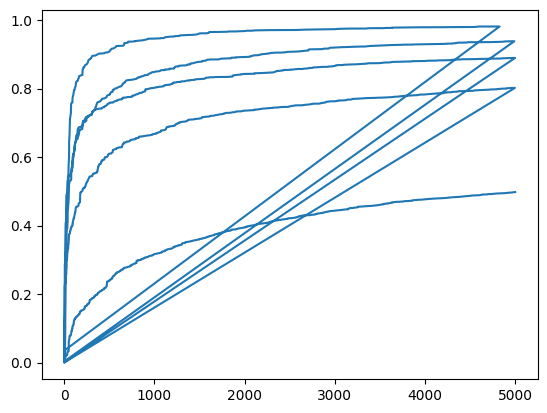

In [7]:
import matplotlib.pyplot as plt
plt.plot(rec_df['n_draws'], rec_df['acc_prob'], label=rec_df['graph_type'])
# FIXME: can't use matplotlib - plot moved to ggplot

In [8]:
rec_df[rec_df['n_nodes'] == 10]

,n_draws,acc_prob,draw_prob,acc_discovery,n_nodes,graph_type
2680,0,0.000139,0.000045,1,10,100-tree
2681,1,0.000139,0.000045,2,10,100-tree
2682,2,0.000163,0.000053,3,10,100-tree
2683,3,0.001437,0.000467,4,10,100-tree
2684,4,0.001576,0.000512,5,10,100-tree
...,...,...,...,...,...,...
5623,4991,0.497189,0.161668,2944,10,100-tree
5624,4993,0.497250,0.161688,2945,10,100-tree
5625,4995,0.497515,0.161774,2946,10,100-tree
5626,4996,0.497515,0.161775,2947,10,100-tree
